In [16]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs
from sklearn.model_selection import train_test_split
from datetime import datetime

In [17]:
major_forex_pairs

['EUR/USD', 'GBP/USD', 'USD/JPY', 'USD/CHF', 'USD/CAD', 'AUD/USD', 'NZD/USD']

In [18]:
freq = 'm15'
conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
ticker = major_forex_pairs[0]
print(ticker)
data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
conn.close()
columns = ['open', 'high', 'low', 'close']
for col in columns:
    data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
data

EUR/USD


,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty,open,high,low,close
date,,,,,,,,,,,,,
2021-07-14 02:30:00,1.17793,1.17807,1.17813,1.17790,1.17805,1.17821,1.17826,1.17803,938,1.177990,1.178195,1.177965,1.178140
2021-07-14 02:45:00,1.17807,1.17834,1.17839,1.17802,1.17821,1.17847,1.17852,1.17814,735,1.178140,1.178455,1.178080,1.178405
2021-07-14 03:00:00,1.17834,1.17832,1.17843,1.17824,1.17847,1.17845,1.17855,1.17836,937,1.178405,1.178490,1.178300,1.178385
2021-07-14 03:15:00,1.17832,1.17833,1.17842,1.17829,1.17845,1.17846,1.17856,1.17842,844,1.178385,1.178490,1.178355,1.178395
2021-07-14 03:30:00,1.17833,1.17834,1.17848,1.17828,1.17846,1.17846,1.17861,1.17841,461,1.178395,1.178545,1.178345,1.178400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03 20:45:00,1.13052,1.13087,1.13090,1.13005,1.13064,1.13099,1.13102,1.13019,1583,1.130580,1.130960,1.130120,1.130930
2021-12-03 21:00:00,1.13086,1.13085,1.13108,1.13057,1.13099,1.13098,1.13120,1.13070,847,1.130925,1.131140,1.130635,1.130915
2021-12-03 21:15:00,1.13084,1.13092,1.13097,1.13073,1.13098,1.13105,1.13112,1.13087,307,1.130910,1.131045,1.130800,1.130985


In [19]:
data['return'] = np.log(data['close']/data['close'].shift(1))

In [20]:
# momentum
# data['signal'] = data['return'].rolling(100).mean().apply(np.sign)
# contrarian
data['signal'] = data['return'].rolling(100).mean().apply(np.sign) *-1

In [21]:
data['signal']

date
2021-07-14 02:30:00    NaN
2021-07-14 02:45:00    NaN
2021-07-14 03:00:00    NaN
2021-07-14 03:15:00    NaN
2021-07-14 03:30:00    NaN
                      ... 
2021-12-03 20:45:00   -1.0
2021-12-03 21:00:00   -1.0
2021-12-03 21:15:00   -1.0
2021-12-03 21:30:00   -1.0
2021-12-03 21:45:00   -1.0
Name: signal, Length: 10000, dtype: float64

In [22]:
data.dropna(axis=0, inplace=True)

In [23]:
print("*** Position counts ***")
print(data['signal'].value_counts())
print("-"*50)
print("*** Trades ***")
print(data['signal'].diff(1).apply(np.abs).value_counts())
print("-"*50)

*** Position counts ***
 1.0    5465
-1.0    4435
Name: signal, dtype: int64
--------------------------------------------------
*** Trades ***
0.0    9421
2.0     478
Name: signal, dtype: int64
--------------------------------------------------


  0%|          | 0/9899 [00:00<?, ?it/s]

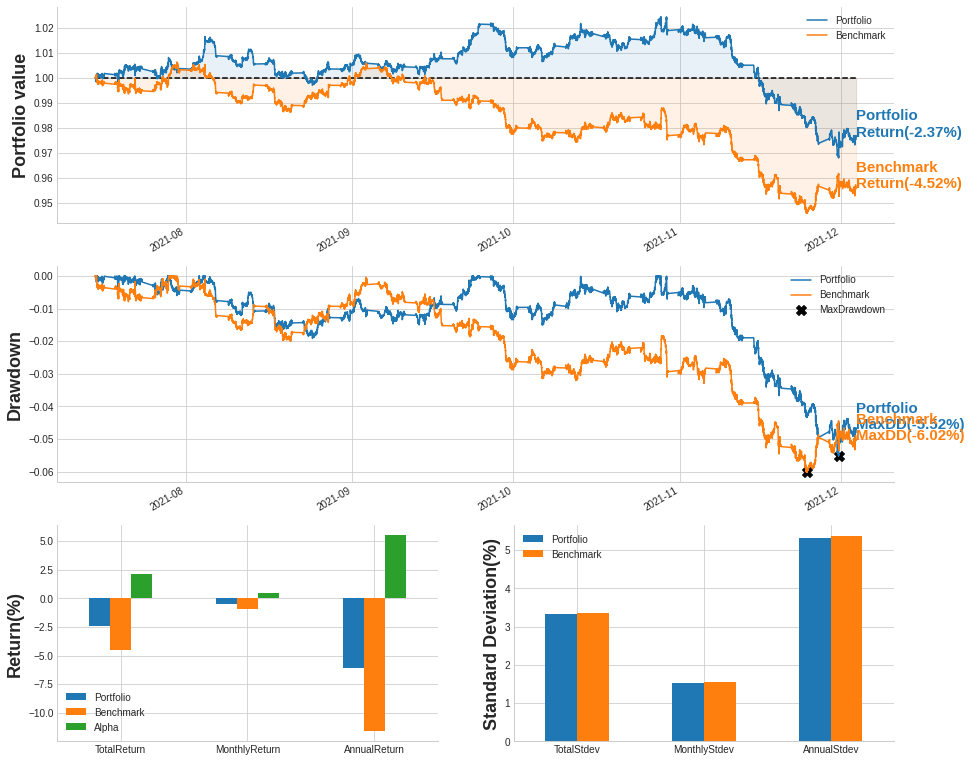

----------------------------------------------------------------------
Data length: |141 days 18:15:00|
Data range from |2021-07-15 03:30:00| to |2021-12-03 21:45:00|
----------------------------------------------------------------------
***** Portfolio Returns in percentage(%) *****
╒═══════════════╤═════════════╤═════════════╤═════════╕
│               │   Portfolio │   Benchmark │   Alpha │
╞═══════════════╪═════════════╪═════════════╪═════════╡
│ TotalReturn   │      -2.370 │      -4.518 │   2.148 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ MonthlyReturn │      -0.502 │      -0.956 │   0.455 │
├───────────────┼─────────────┼─────────────┼─────────┤
│ AnnualReturn  │      -6.103 │     -11.634 │   5.531 │
╘═══════════════╧═════════════╧═════════════╧═════════╛
***** Portfolio Standard Deviation in percentage(%) *****
╒══════════════╤═════════════╤═════════════╕
│              │   Portfolio │   Benchmark │
╞══════════════╪═════════════╪═════════════╡
│ TotalStdev   │  

In [24]:
backtest = IterativeBacktester(data=data,
                               signals=data['signal'],
                               freq=freq)
backtest.backtest()
backtest.results()